# Pupil to Hypnogram

Estimate sleep states from pupil dynamics features, , Pupil-diameter, -location, -velocity, and eyelid opening.

## Only need to change current directory!

Default data is below:
- Pupil input features: 
 - ../Data/Intermediate/MATLAB/Outputs/pupil/PD_ratio.csv

- Output hypnogram:
 - ../Data/Outputs




## Preparation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch

from typing import List
from matplotlib.colors import ListedColormap
from tqdm.notebook import tqdm

### Change the path into your own directory structure!!



In [3]:
#change directory
os.chdir('/content/drive/Shareddrives/P2H/Github_public/Code/')#←change here!!
print("current working directory:", os.getcwd())

#import original code
#from my_module.utils import *
from my_module.utils import *
from my_module.model.LSTM_w import *

current working directory: /content/drive/Shareddrives/P2H/Github_public/Code


In [4]:
# set seed 
random_seed = 123
torch.manual_seed(random_seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)
#var_dict['random_seed'] =  random_seed

device: cuda


In [5]:
# set variables
var_dict = {
    'freq_pupil' : 10, #sampling rate of pupil data
    'freq_hyp' : 0.1, #sampling rate of hypnogram?
    'length' : 10, #time length of input data
    
    #hyperparameter
    'batch_size' : 2048, 
    
    #LSTM
    'hidden_dim' : 32, #2, 4, 128, 512
    'layer_num' : 1,
    'dropout_rate' : 0.5,
    'n_class' : 3,

    #weighted cross entropyloss
    'weights' : torch.FloatTensor([1.58,19.3, 3.16]).to(device),

    #learning rate
    'lr' : 0.00075, #0.0005, 0.001

    #number of sessions for test 
    'test_num' : 5,

    #GPU
    'device' : device,

    #random seed
    'random_seed' : random_seed,

    #feature
    "coordinate_feature" : [1,1,1,1,1,1,1,1], 
    #["PR_x", "PC_x", "UEM_x", "LEM_x", "PR_y", "PC_y", "UEM_y", "LEM_y"]
    
    #input path
    "input_dir" : "pupil",
    "data_dim": 5,
}


In [12]:
Path_default = "../Data/Intermediate/MATLAB/Outputs"
Filename_list =  ['PD_ratio.csv', 'Pupil_velocity.csv', 'EyeOpening_ratio.csv', 'PupilLocation.csv']
Path_pupil = [f'{Path_default}/pupil/{name.split(".")[0]}{var_dict["freq_pupil"]}Hz.csv' for name in Filename_list]
[print("path pupil:", path) for path in Path_pupil]

var_dict["length_num"] = int(var_dict["freq_pupil"] * var_dict["length"])
var_dict["filename_list"] = [f'{name.split(".")[0]}{var_dict["freq_pupil"]}Hz.csv' for name in Filename_list]
var_dict["Path_default"] = Path_default
 

path pupil: ../Data/Intermediate/MATLAB/Outputs/pupil/PD_ratio10Hz.csv
path pupil: ../Data/Intermediate/MATLAB/Outputs/pupil/Pupil_velocity10Hz.csv
path pupil: ../Data/Intermediate/MATLAB/Outputs/pupil/EyeOpening_ratio10Hz.csv
path pupil: ../Data/Intermediate/MATLAB/Outputs/pupil/PupilLocation10Hz.csv


## Create Data info

In [7]:
data_info = pd.Series(Path_pupil[0]).str.split("/", expand=True)
data_info = data_info[[2,3]]
data_info.reset_index(drop=True, inplace=True)
data_info["length"] = np.zeros(data_info.shape[0], dtype=int)
data_info["length"] = len(pd.read_csv(Path_pupil[0], header=None))//100*100
data_info.columns = ['animal', 'data', 'length']

# Checking data

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f51fca73590>,
      dtype=object)

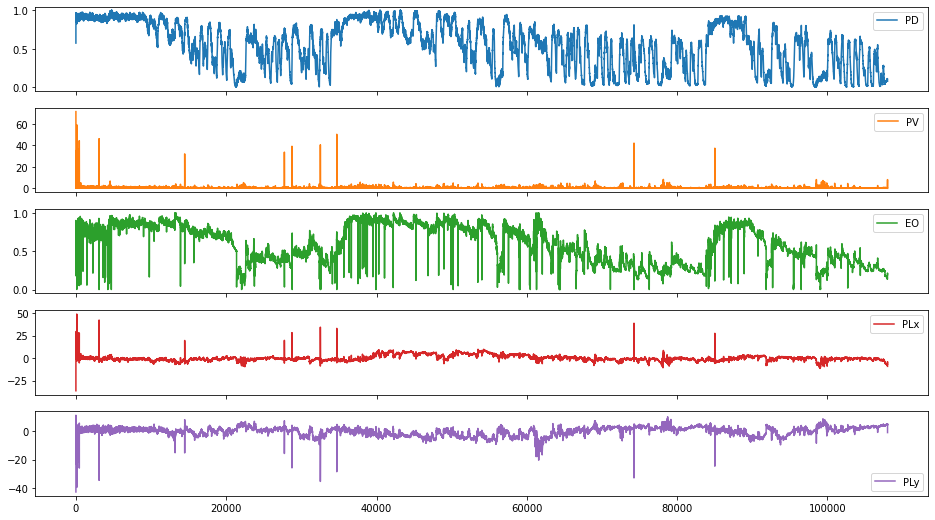

In [8]:
#Plot data
df = pd.concat([pd.read_csv(path, header=None) for path in Path_pupil], axis=1)
df.columns = ["PD", "PV", "EO", "PLx", "PLy"]
df.plot(subplots=True, sharex=True, figsize=(16,9))

# Main

In [9]:
#model load
model = LSTM(**var_dict).to(device)
criterion, optimizer = loss_opt(model=model, **var_dict)
path_load = f'../Data/Intermediate/LSTM/Weights/LSTMoptim.pth'
checkpoint = torch.load(path_load)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [10]:
#load data info
df_info = cal_datanum(data_info, **var_dict)
df_info

,animal,data,length,datanum,cum_datanum,start_num
0,Intermediate,MATLAB,108000,1079,1079,0


In [13]:
#create dataset and dataloader
Dataset = P2HDataset(data_info=df_info, phase="test", **var_dict)
Dataloader = torch.utils.data.DataLoader(
    Dataset,
    batch_size=var_dict['batch_size'],
    drop_last=False
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
phase = 'val'
hyp = []
preds = []
for x in tqdm(Dataloader):
  x = x.float().to(device=device)
  outputs = model(x, var_dict["layer_num"])
  hyp.append(torch.max(outputs[2][:, 0:3], 1)[1].to('cpu').detach().numpy().copy())
  preds.append(outputs[2][:, 0:3].to('cpu').detach().numpy().copy())


  0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
df_result = pd.DataFrame([hyp[0], preds[0][:, 0], preds[0][:, 1], preds[0][:, 2]], index=["preds", "lhN", "lhR", "lhW"]).T
df_result.to_csv(f"{Path_default}/estimatedHypnoScore.csv")

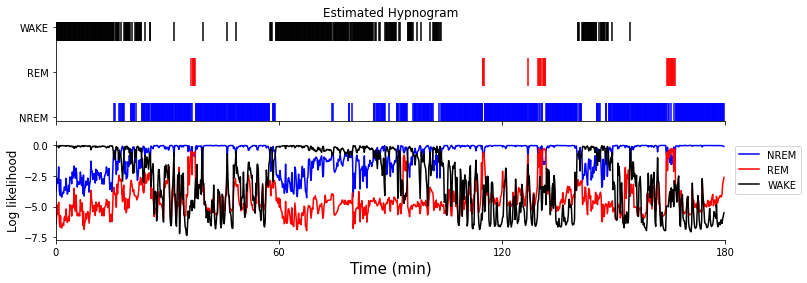

In [16]:
fig, axes = plt.subplots(2,1, figsize=(12, 4), sharex="col")
my_cmap  = ListedColormap(['blue', 'red', 'black'])
width = 0.4
axes[0].scatter(df_result.index, df_result["preds"], c = df_result["preds"], cmap=my_cmap,
                   marker = "|", s=800, linewidths=width)
axes[0].set_title("Estimated Hypnogram")
axes[0].set_yticks([0.0, 1.0, 2.0])
axes[0].set_yticklabels(['NREM', 'REM', 'WAKE'])


    
for i in range(3):
    axes[1].plot(df_result.index, df_result.iloc[:, i+1], color=["blue", "red", "k"][i], label=["NREM", "REM", "WAKE"][i], markersize=1)
axes[1].legend(bbox_to_anchor=(1.12, 1), loc='upper right')
axes[1].set_ylabel("Log likelihood", fontsize=12)
axes[1].set_xticks([0, 360, 720, 1080])
axes[1].set_xticklabels(["0", "60", "120", "180"])
axes[1].set_xlabel("Time (min)", fontsize=15)
axes[1].set_xlim([0, 1080])

[axes[i].spines[j].set_visible(False) for i in range(2) for j in ["top", "right"]]

fig.savefig(f'../Data/Outputs/LSTMestimation.png')